In [1]:
import numpy as np
from torch_geometric.nn import global_add_pool

In [2]:
%load_ext autoreload
%autoreload 2
from rdkit import RDLogger    
from torch_geometric.data import Data
RDLogger.DisableLog('rdApp.*')
from util_gnn import draw_graph
import torch

In [11]:
import os
generator = torch.load(os.path.join('../models/', f'ul_gan_qm9.pt'))
_ = generator.eval()

In [12]:
from trainer import generate_noise
from util_molecular import MolFromTorchGraphData, evaluate, MolFromTorchGraphData_enriched

In [418]:
eval_fake_data = []

z_rand, z_lr_cont, z_cate, z_cont = generate_noise(device=device, rand_dim=256)
z = z_rand
fake_data, probs = generator(z)
eval_fake_data.extend([fake_data[j] for j in range(fake_data.batch.max().item() + 1)])
eval_fake_data = [MolFromTorchGraphData_enriched(j.to('cpu'), node_dim=4, without_aroma=True) for j in eval_fake_data]


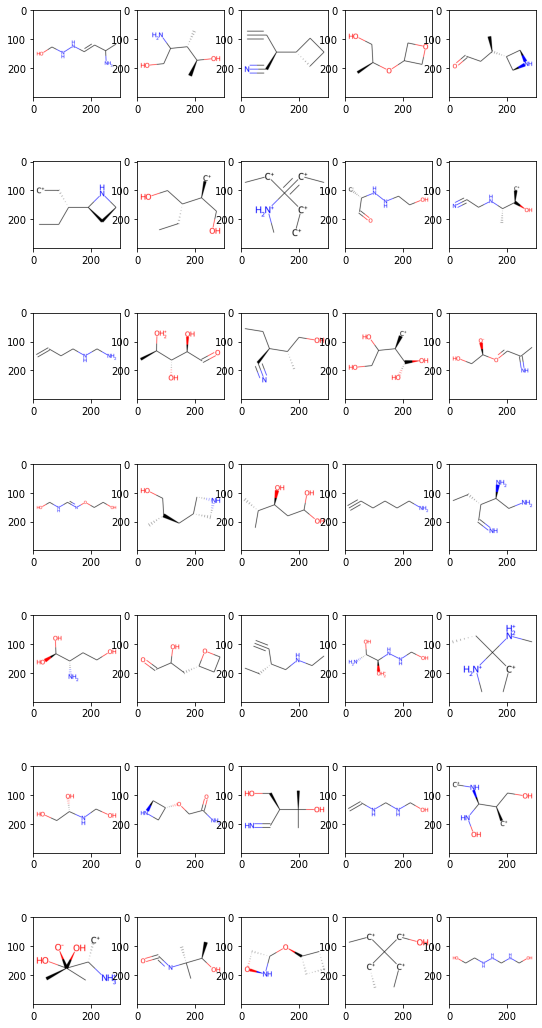

In [422]:
%matplotlib inline
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

st = 4
fig, ax = plt.subplots(7, 5, figsize=(9, 19))
for i in range(st, st+7):
    for j in range(5):
        ax[i-st, j].imshow(Draw.MolToImage(eval_fake_data[i*5 + j]))



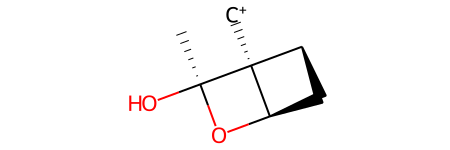

In [427]:
# Pick z0 and z1.
z1 = z[2]
mol1 = eval_fake_data[2]
mol1

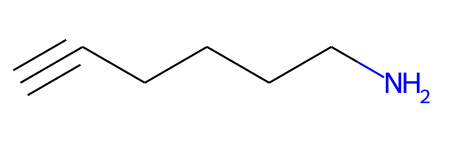

In [424]:
z0 = z[38]
mol0 = eval_fake_data[38]
mol0

In [425]:
all_zs = []
for t in np.linspace(0.1, 0.9, 5):
    all_zs.append(z0.reshape(1, -1)*(1-t) + z1.reshape(1, -1)*t)
all_zs = torch.cat(all_zs, axis=0)
use_allzs = torch.cat([all_zs, all_zs, all_zs, all_zs, all_zs, all_zs]*10, axis=0)
evol_data = []
fake_data, probs = generator(use_allzs)
evol_data.extend([fake_data[j] for j in range(fake_data.batch.max().item() + 1)])
evol_data = [MolFromTorchGraphData_enriched(j.to('cpu'), node_dim=4, without_aroma=True) for j in evol_data]

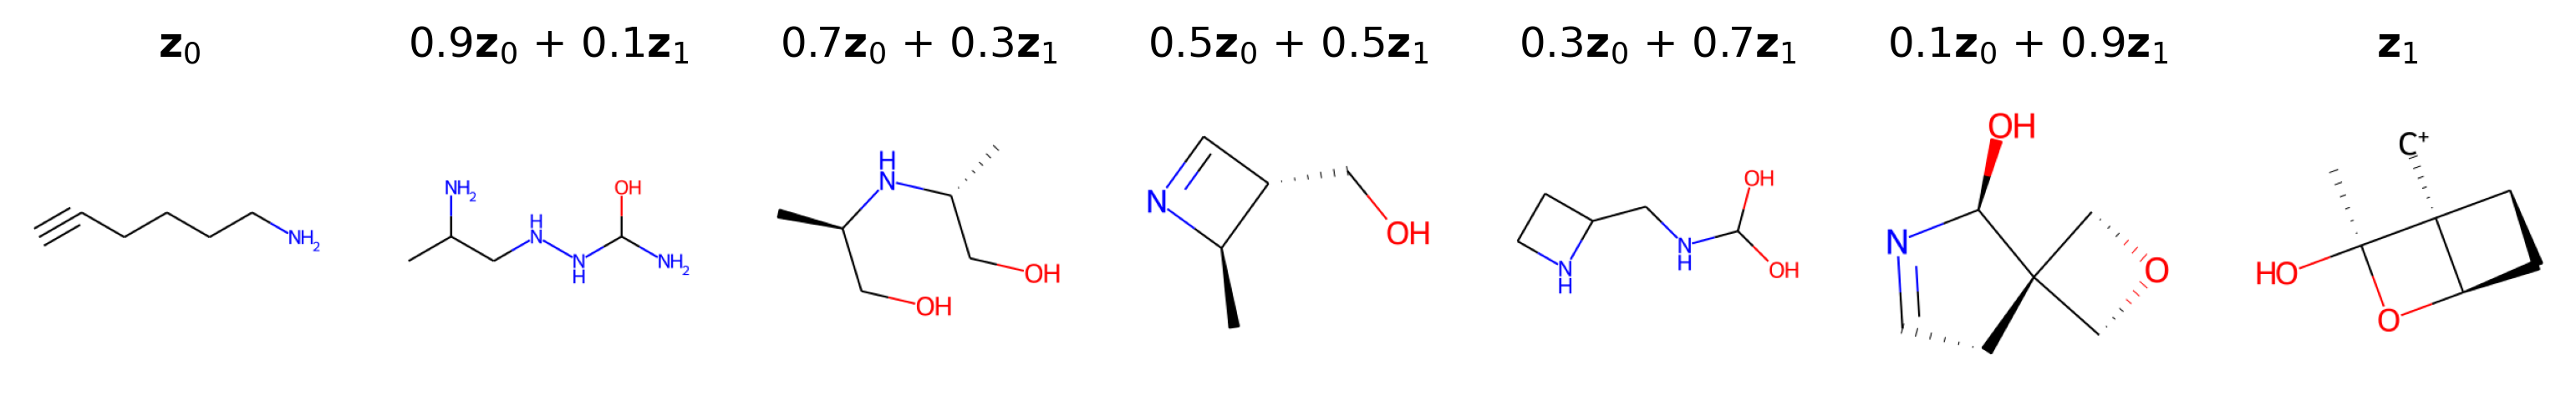

In [542]:
fig, ax = plt.subplots(1, 7, figsize=(13, 4), dpi=300)
ax[0].imshow(Draw.MolToImage(mol0))
ax[0].set_axis_off()
ax[0].set_title('$\mathbf{z}_0$')
sts = [25]*5
for j, st in enumerate(sts):
    ax[j+1].imshow(Draw.MolToImage(evol_data[st*5 + j]))
    ax[j+1].set_axis_off()
    z0 = "\mathbf{z}_0"
    z1 = "\mathbf{z}_1"
    ax[j+1].set_title(f'{(1-np.linspace(0.1, 0.9, 5)[j]).round(1)}${z0}$ + {(np.linspace(0.1, 0.9, 5)[j]).round(1)}${z1}$')
#     ax[j+1].arrow(150, -20, 0, 20, width=5)
ax[6].imshow(Draw.MolToImage(mol1))
ax[6].set_axis_off()
ax[6].set_title('$\mathbf{z}_1$')
# ax[6].arrow(150, -20, 0, 20, width=5)
fig.savefig('Series1_v2')